## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training')]

In [6]:
doc(ImageItemList)

In [7]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [8]:
il.items[0]

PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/9/1417.png')

In [9]:
defaults.cmap='binary'

In [10]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png

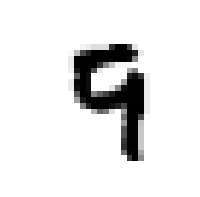

In [11]:
il[0].show()

In [12]:
sd = il.split_by_folder(train='training', valid='testing')

In [13]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [14]:
(path/'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1')]

In [15]:
(path/'testing').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/1')]

In [16]:
ll = sd.label_from_folder()

In [17]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 9, Category 9, Category 9, Category 9, Category 9]...
Path: /home/jupyter/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 9, Category 9, Category 9, Category 9, Category 9]...
Path: /home/jupyter/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [18]:
x,y = ll.train[0]

9 torch.Size([1, 28, 28])


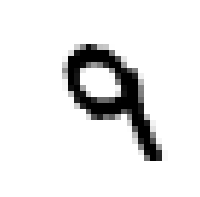

In [19]:
x.show()
print(y,x.shape)

In [20]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [21]:
ll = ll.transform(tfms)

In [23]:
doc(rand_pad)

In [24]:
bs = 128

In [25]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [26]:
x,y = data.train_ds[0]

9


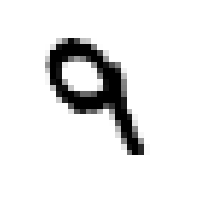

In [27]:
x.show()
print(y)

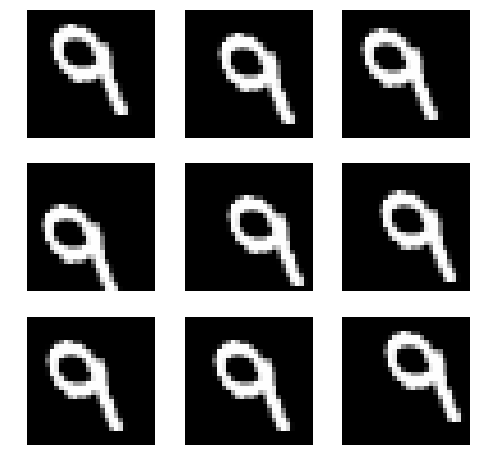

In [28]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [29]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

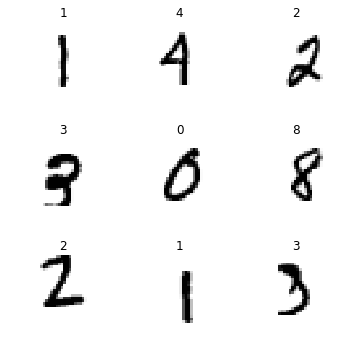

In [30]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [31]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [32]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [33]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [34]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [128, 8, 14, 14]     80         True      \n______________________________________________________________________\nBatchNorm2d          [128, 8, 14, 14]     16         True      \n______________________________________________________________________\nReLU                 [128, 8, 14, 14]     0          False     \n______________________________________________________________________\nConv2d               [128, 16, 7, 7]      1168       True      \n______________________________________________________________________\nBatchNorm2d          [128, 16, 7, 7]      32         True      \n______________________________________________________________________\nReLU                 [128, 16, 7, 7]      0          False     \n________________________________________

In [35]:
xb = xb.cuda()

In [36]:
model(xb).shape

torch.Size([128, 10])

In [37]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


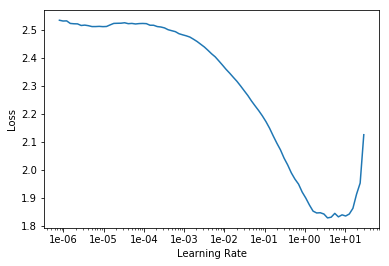

In [38]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.220413,0.177681,0.944000
2,0.133222,0.072488,0.977400
3,0.074403,0.039634,0.987900


### Refactor

In [40]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [41]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [42]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [43]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.248256,0.442313,0.850100
2,0.188170,0.227824,0.931100
3,0.162524,0.161361,0.954100
4,0.141956,0.127220,0.962200
5,0.116286,0.135104,0.959100
6,0.090904,0.063231,0.980200
7,0.086274,0.050913,0.982500
8,0.058925,0.053686,0.981800
9,0.050082,0.031199,0.989300
10,0.049125,0.029299,0.989600


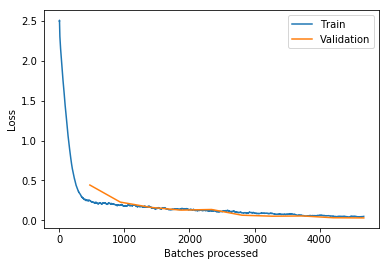

In [44]:
learn.recorder.plot_losses()

### Resnet-ish

In [45]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [46]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **kwargs)
    Resnet block of `nf` features.



In [47]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [48]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [49]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [50]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


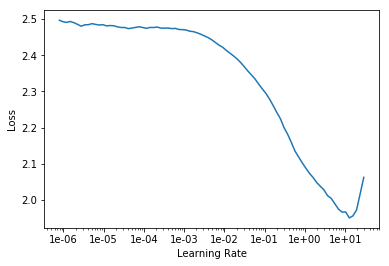

In [51]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.236067,0.193792,0.951100
2,0.126396,0.151852,0.948500
3,0.118096,0.160212,0.952300
4,0.089783,0.081474,0.972700


In [ ]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

## fin